In [1]:
from __future__ import print_function
import numpy as np
import torch 
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

def geometricPad(grid, pad=1):
  M = grid.shape[2]; # 0:batchsize, 1:channels, 2:width, 3:height
  M_new = pad+M+pad;
  new_shape = (grid.shape[0], grid.shape[1], M_new, M_new)
  grid_new = grid.new_zeros(new_shape);
  grid_new[:,:,pad:M+pad,pad:M+pad] = grid;
  grid_new[:,:,0:pad,pad:(M+pad)] = grid[:,:,:,0:pad].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),0:pad] = grid[:,:,0:pad,:].flip(-2).transpose(-1,-2);
  grid_new[:,:,(M+pad):(M+pad+pad),(pad):(M+pad)] = grid[:,:,:,(M-pad):].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),(M+pad):(M+pad+pad)] = grid[:,:,(M-pad):,:].flip(-2).transpose(-1,-2);
  return(grid_new);

In [2]:
def imshowRdBu(ax,img):
    minmax = max(torch.max(img),-torch.min(img))
    return ax.imshow(-img,cmap='RdBu',vmin=-minmax,vmax=minmax)

## Load network

In [3]:
from torch.utils.data import Dataset, DataLoader

class H5Dataset(Dataset):

    def __init__(self, files, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename                                                                     
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        # for d in data_dirs:
        #     file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
        #     if limit_num_files: file_list = file_list[0:limit_num_files]
        #     self._files += file_list
        self._files = files

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        import h5py
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        label = fh['labels'][entry_index]
        #labelTranslation = [-1,0,1,-1,2] # make sure that labels 1,2,4 get values 0,1,2
        if label == 1: # electron
            label = 0
        elif label == 2: # muon
            label = 1
        elif label == 4: # pip
            label = 2
        else:
            print('Unknown label', label, 'for entry_index', entry_index, 'treating as label=0')
            label = 0
        
        # try:
        #     label = labelTranslation[label]
        # except IndexError:
        #     print('IndexError at entry', entry_index, 'label in file was', fh['labels'][entry_index], 'translations are', labelTranslation)
        #     raise
        
        event_data = fh['event_data'][entry_index]
        return event_data[:,:,0:1],label,idx

def HKCollate(batch):
    data  = np.stack([sample[0] for sample in batch])
    label = [sample[1] for sample in batch]
    idx   = [sample[2] for sample in batch]
    return data,label,idx

In [4]:
# also add more data

#mcdir = '/home/lukasb/projects/rpp-tanaka-ab/lukasb/watchmal/20190808-uniisoflat'
mcdir = '/home/lukasb/scratch/20190808-uniisoflat'
wallmat = 'blacksheet'
pnames = ('e','mu','pip')
files = ['%s/1R%s-%s/wc-0-bch%d.h5' % (mcdir,pname,wallmat,bch+1) for bch in range(100) for pname in pnames]

train_ds = H5Dataset(files,start_fraction=0.0,use_fraction=0.9);
test_ds  = H5Dataset(files,start_fraction=0.9,use_fraction=0.1);

# for training
train_loader=DataLoader(train_ds,batch_size= 64,shuffle=True,num_workers=4,collate_fn=HKCollate)
# for validation
test_loader =DataLoader( test_ds,batch_size=200,shuffle=True,num_workers=2,collate_fn=HKCollate)

In [5]:
class BNConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout,pad):
        super(BNConv2d, self).__init__()
        self.batchNorm2d = torch.nn.BatchNorm2d(Cin)
        self.conv2d = torch.nn.Conv2d(Cin,Cout,2*pad+1,padding=pad)
 
    def forward(self, x):
        x = self.batchNorm2d(x)
        return self.conv2d(x)

class GeomBNConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout,pad):
        super(GeomBNConv2d, self).__init__()
        self.Cin = Cin
        self.Cout = Cout
        self.pad = pad
        self.batchNorm2d = torch.nn.BatchNorm2d(Cin)
        self.conv2d = torch.nn.Conv2d(Cin,Cout,2*self.pad+1)
 
    def forward(self, x):
        x = self.batchNorm2d(x)
        inputsPad = geometricPad(x, self.pad); # (B,C,W,H)
        return self.conv2d(inputsPad)

class TaylorBNConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout,taylor):
        super(TaylorBNConv2d, self).__init__()
        self.Cin = Cin
        self.Cout = Cout
        self.taylor = taylor
        self.batchNorm2d = torch.nn.BatchNorm2d(Cin*taylor.Ntaylor)
        self.conv2d = torch.nn.Conv2d(Cin*taylor.Ntaylor,Cout,1)
 
    def forward(self, x):
        x = self.taylor(x)
        x = self.batchNorm2d(x)
        x = self.conv2d(x)
        return x
    
    # the default implementation of cpu() and cuda() only passes this along to nn.Module instances
    # since self.AA is a tensor, we need to take care of it ourselves
    
    def cpu(self):
        super(TaylorBNConv2d, self).cpu()
        self.taylor.cpu()
        return self
    
    def cuda(self):
        super(TaylorBNConv2d, self).cuda()
        self.taylor.cuda()
        return self


class BNCNN(torch.nn.Module):
    
    def __init__(self, num_class):
        super(BNCNN, self).__init__()
        
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            BNConv2d( 1,16,1), torch.nn.ReLU(),
            BNConv2d(16,32,1), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            BNConv2d(32,32,1), torch.nn.ReLU(),
            BNConv2d(32,32,1), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            BNConv2d(32,64,1), torch.nn.ReLU(),
            BNConv2d(64,64,1), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            BNConv2d( 64,128,1), torch.nn.ReLU(),
            BNConv2d(128,128,1), torch.nn.ReLU()
        )
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(128,32), torch.nn.ReLU(),
            torch.nn.Linear(32,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,128))
    
    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
    
    def cpu(self):
        super(BNCNN, self).cpu()
        for module in self._feature:
            module.cpu()
        for module in self._classifier:
            module.cpu()
        return self
    
    def cuda(self):
        super(BNCNN, self).cuda()
        for module in self._feature:
            module.cuda()
        for module in self._classifier:
            module.cuda()
        return self

In [9]:
def forward(blob,train=True):
    """
       Args: blob should have attributes, net, criterion, softmax, data, label
       Returns: a dictionary of predicted labels, softmax, loss, and accuracy
    """
    with torch.set_grad_enabled(train):
        # Prediction
        data = torch.as_tensor(blob.data).cuda()#[torch.as_tensor(d).cuda() for d in blob.data]
        data = data.permute(0,3,1,2)
        prediction = blob.net(data)
        # Training
        loss,acc=-1,-1
        if blob.label is not None:
            label = torch.as_tensor(blob.label).type(torch.LongTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            #label = torch.as_tensor(blob.label).type(torch.FloatTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            label.requires_grad = False
            loss = blob.criterion(prediction,label)
        blob.loss = loss
        
        softmax    = blob.softmax(prediction).cpu().detach().numpy()
        prediction = torch.argmax(prediction,dim=-1)
        accuracy   = (prediction == label).sum().item() / float(prediction.nelement())
        # mse        = blob.mse(prediction,label).cpu().detach().numpy()
        # accuracy   = np.sqrt(mse.mean()).item()
        prediction = prediction.cpu().detach().numpy()
        
        return {'prediction' : prediction,
                'softmax'    : softmax,
                'loss'       : loss.cpu().detach().item(),
                'accuracy'   : accuracy}

def backward(blob):
    blob.optimizer.zero_grad()  # Reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()

def save_state(blob):
    # Output file name
    filename = '%s-%d.ckpt' % (blob.prefix, blob.iteration)
    # Save parameters
    # 0+1) iteration counter + optimizer state => in case we want to "continue training" later
    # 2) network weight
    torch.save({
        'global_epoch': blob.epoch,
        'global_step': blob.iteration,
        'optimizer': blob.optimizer.state_dict(),
        'state_dict': blob.net.state_dict()
        }, filename)
    return filename

def restore_state(blob, iteration):
    # Open a file in read-binary mode
    weight_file = '%s-%d.ckpt' % (blob.prefix, iteration)
    with open(weight_file, 'rb') as f:
        # torch interprets the file, then we can access using string keys
        checkpoint = torch.load(f)
        # load network weights
        blob.net.load_state_dict(checkpoint['state_dict'], strict=False)
        # if optimizer is provided, load the state of the optimizer
        if blob.optimizer is not None:
            blob.optimizer.load_state_dict(checkpoint['optimizer'])
        # load iteration count
        blob.epoch     = checkpoint['global_epoch']
        blob.iteration = checkpoint['global_step']

# weight_file = save_state(blob, '20190819-02-DeepTaylor-01-BatchNorm')
# print('Saved to', weight_file)


# # Recreate the network (i.e. initialize)
# blob.net=LeNet().cuda()
# # Get one batch of data to test
# blob.data, blob.label = next(iter(train_loader))
# # Run forward function
# res = forward(blob,True)
# # Report
# print('Accuracy:',res['accuracy'])



# # Restore the state
# restore_state(weight_file,blob)
# # Run the forward function
# res = forward(blob,True)
# # Report
# print('Accuracy',res['accuracy'])

In [7]:
class BLOB:
    pass
blob=BLOB()
blob.net       = BNCNN(3).cuda() # construct CNN for 1 variable regression, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.prefix    = '20190819-08-DeepConv-trainMore-50k-01-BNCNN'
blob.epoch     = 0.
blob.iteration = 0
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

In [10]:
restore_state(blob, 7930)

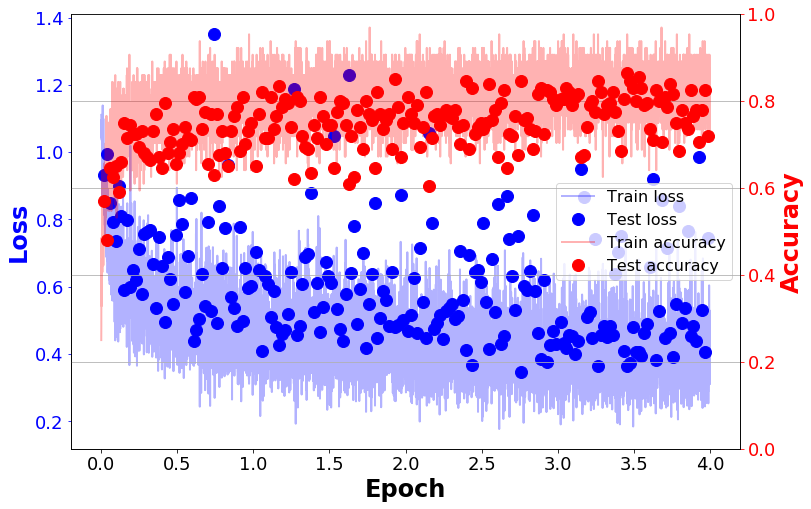

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from utils.utils import CSVData
%matplotlib inline

blob.train_log, blob.test_log = CSVData('%s-log_train.csv' % blob.prefix), CSVData('%s-log_test.csv' % blob.prefix)

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

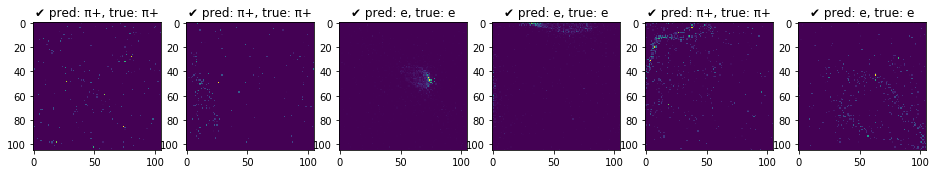

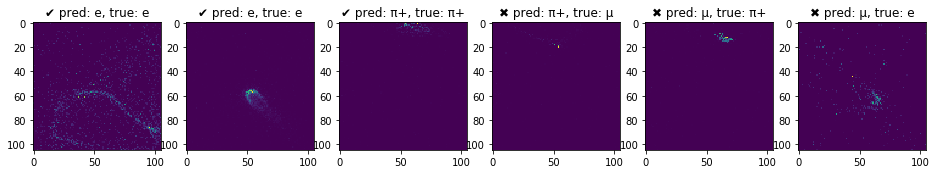

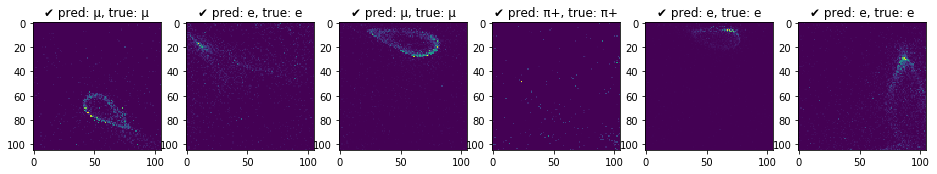

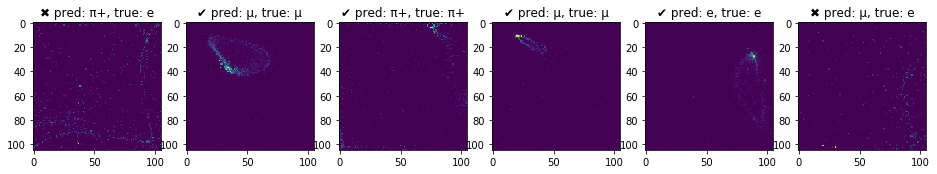

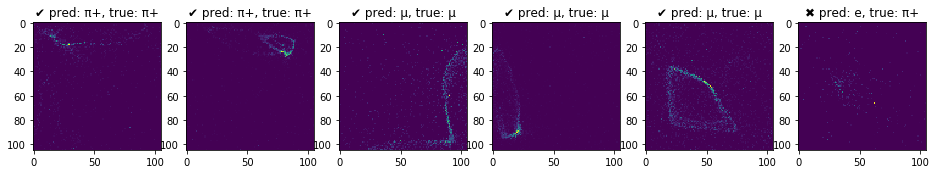

In [12]:
with torch.no_grad():
    Nrows = 5
    for r in range(Nrows):
        Nplot = 6
        fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')

        with torch.no_grad():
            blob.net.eval()
            test_data = next(iter(test_loader))
            blob.data,blob.label = test_data[0:2]
            blob.data  = blob.data[0:Nplot,:,:,:]
            blob.label = blob.label[0:Nplot]
            res = forward(blob,True)

            for ev in range(Nplot):
                im = axes[ev].imshow(blob.data[ev,:,:,0])
                labelNames = ['e','μ','π+']
                correct = (blob.label[ev] == res['prediction'][ev])
                axes[ev].set_title('%s pred: %s, true: %s' % ('✔︎' if correct else '✖︎', labelNames[blob.label[ev]], labelNames[res['prediction'][ev]]))
                #cbar = fig.colorbar(im, ax=axes[ev])
            plt.show()
            
            del test_data
            del blob.data
            del blob.label

In [13]:
def inference(blob,data_loader):
    label,prediction,accuracy=[],[],[]
    with torch.no_grad():
        # set the network to test (non-train) mode
        blob.net.eval()
        # create the result holder
        index,label,prediction = [],[],[]
        for i,data in enumerate(data_loader):
            blob.data, blob.label = data[0:2]
            res = forward(blob,True)
            accuracy.append(res['accuracy'])
            prediction.append(res['prediction'])
            label.append(blob.label)
            #if i==2: break
        # report accuracy
        del blob.data
        del blob.label
        del data
    accuracy   = np.array(accuracy,dtype=np.float32)
    label      = np.hstack(label)
    prediction = np.hstack(prediction)
    
    return accuracy, label, prediction

Accuracy mean 0.80452126 std 0.0488898


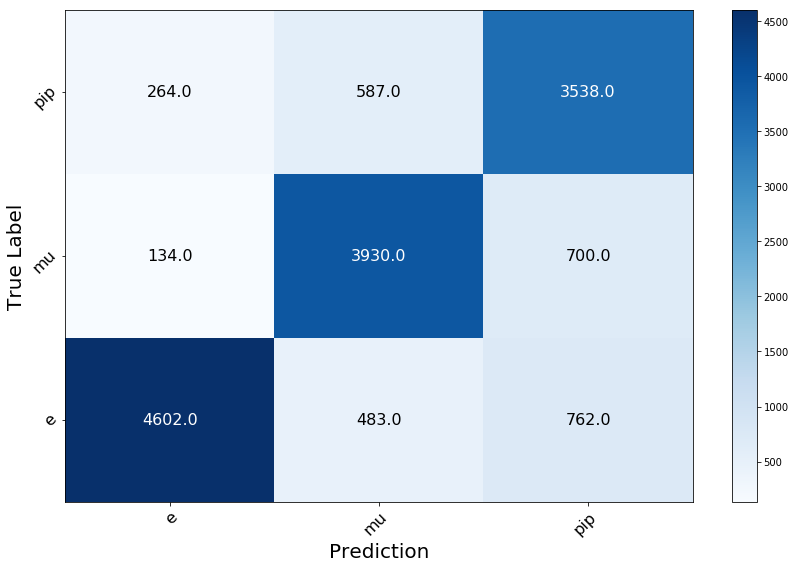

In [14]:
from utils.utils import plot_confusion_matrix

inference_loader = DataLoader( test_ds,batch_size=64,shuffle=True,num_workers=2,collate_fn=HKCollate)

accuracy,label,prediction = inference(blob, inference_loader)
print('Accuracy mean',accuracy.mean(),'std',accuracy.std())
plot_confusion_matrix(label,prediction,['e','mu','pip'])

In [22]:
print('stderr', accuracy.std() / np.sqrt(accuracy.shape[0]))

stderr 0.0031892189617095702


as usual beware because the labels "True" and "Prediction" are switched.

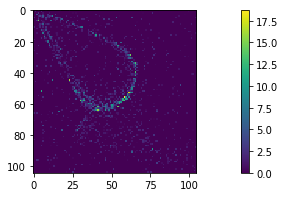

_feature 0 BNConv2d(
  (batchNorm2d): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


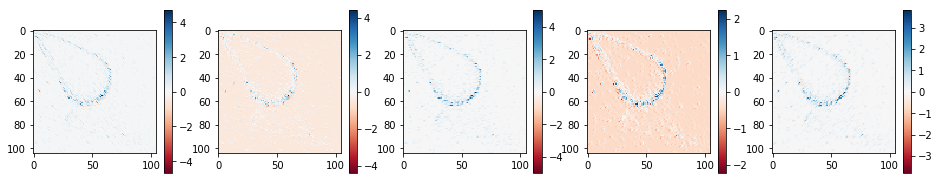

_feature 1 ReLU()


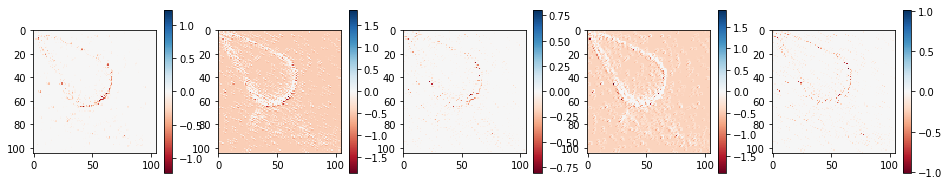

_feature 2 BNConv2d(
  (batchNorm2d): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


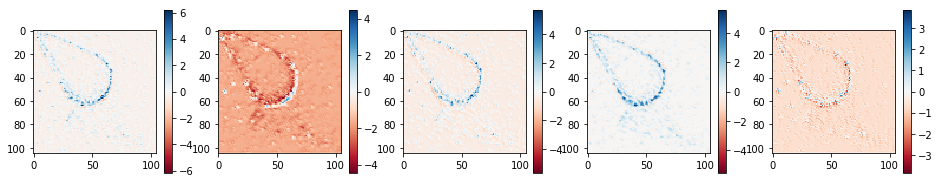

_feature 3 ReLU()


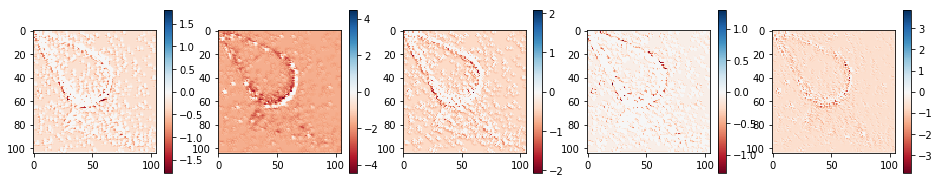

_feature 4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


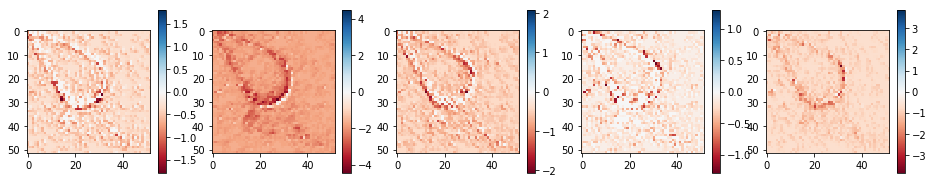

_feature 5 BNConv2d(
  (batchNorm2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


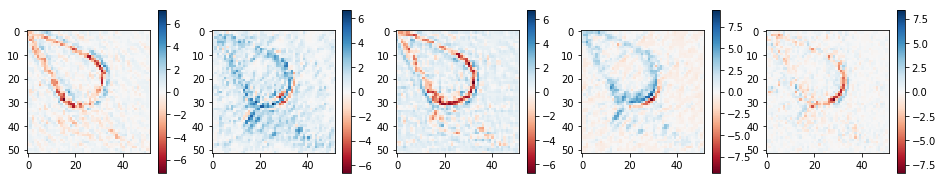

_feature 6 ReLU()


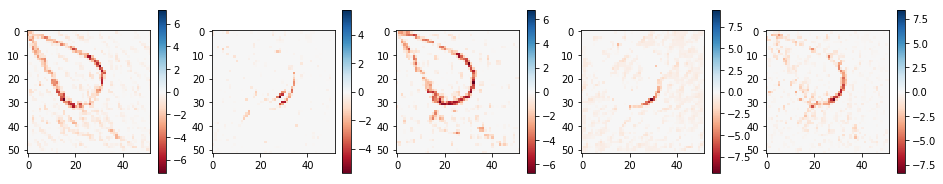

_feature 7 BNConv2d(
  (batchNorm2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


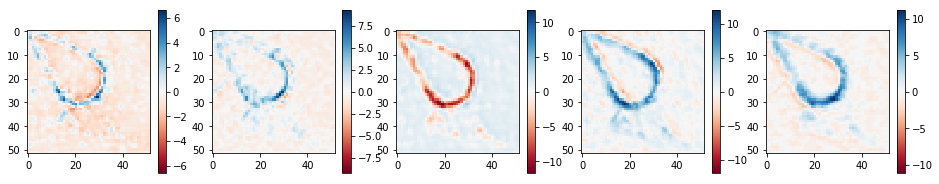

_feature 8 ReLU()


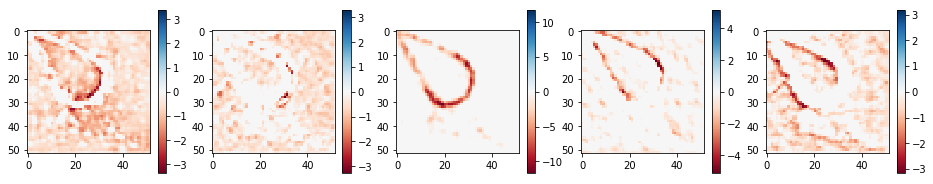

_feature 9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


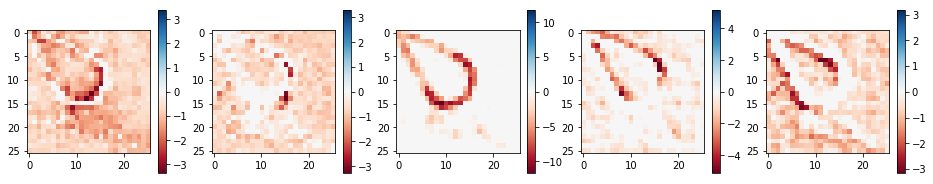

_feature 10 BNConv2d(
  (batchNorm2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


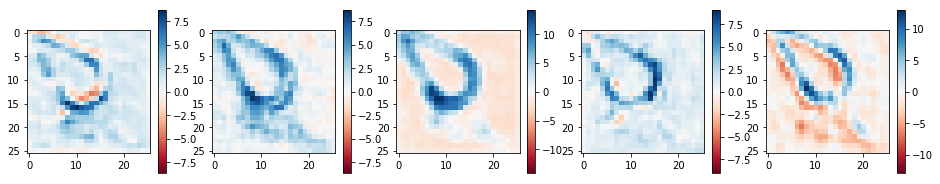

_feature 11 ReLU()


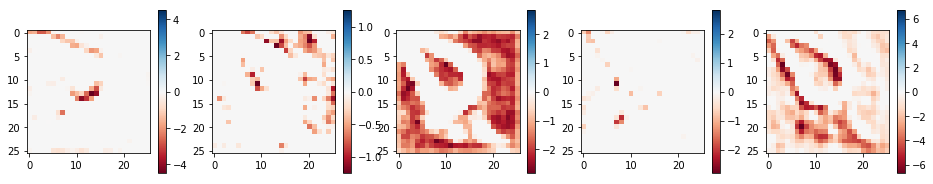

_feature 12 BNConv2d(
  (batchNorm2d): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


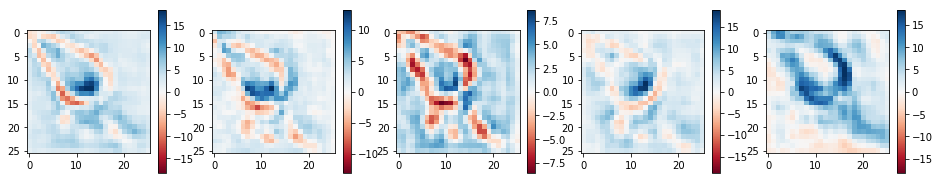

_feature 13 ReLU()


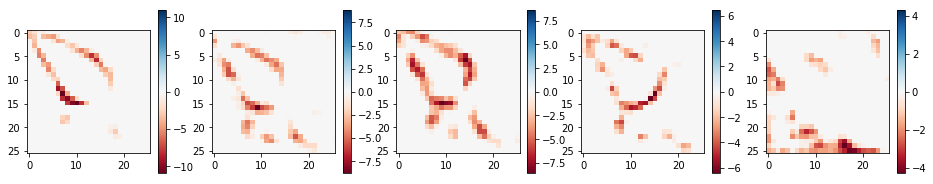

_feature 14 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


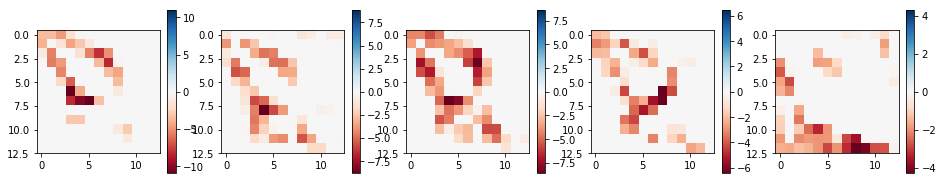

_feature 15 BNConv2d(
  (batchNorm2d): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


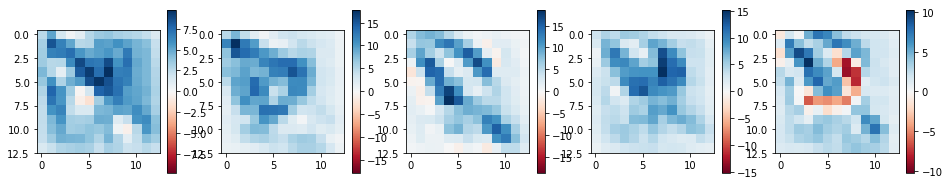

_feature 16 ReLU()


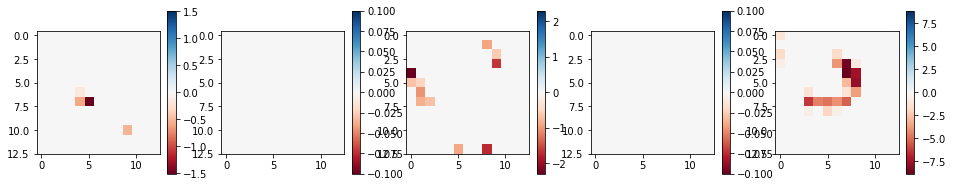

_feature 17 BNConv2d(
  (batchNorm2d): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


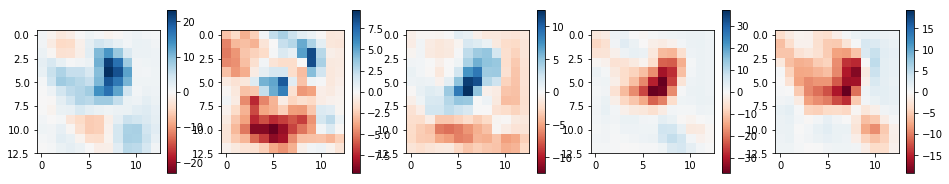

_feature 18 ReLU()


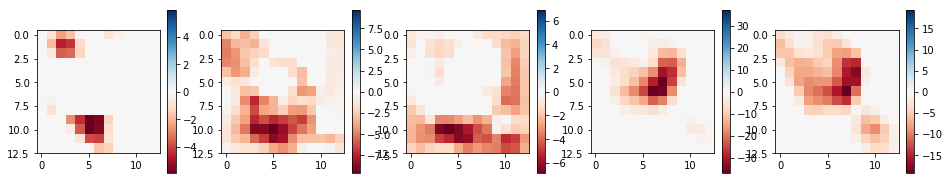

torch.Size([200, 128, 13, 13]) after _feature
torch.Size([200, 128, 1, 1]) after AvgPool2d
torch.Size([200, 128]) after view


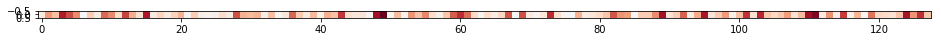

_classifier 0 Linear(in_features=128, out_features=32, bias=True)


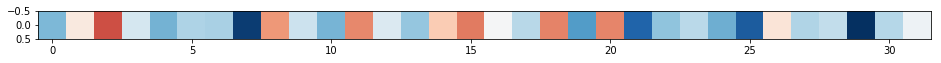

_classifier 1 ReLU()


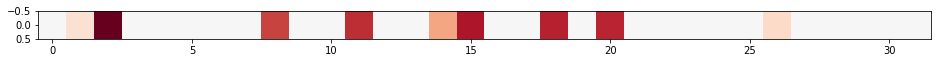

_classifier 2 Linear(in_features=32, out_features=3, bias=True)


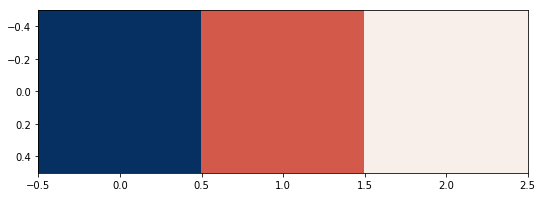

In [23]:
with torch.no_grad():
    blob.net.eval()
    test_data = next(iter(test_loader))
    blob.data,blob.label = test_data[0:2]
    
    data = torch.as_tensor(blob.data).cuda()
    data = data.permute(0,3,1,2)
    # prediction = blob.net(data)
    
    ev=1
    
    fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
    im = ax0.imshow(data[ev,0,:,:].cpu())
    cbar = ax0.figure.colorbar(im, ax=ax0)
    plt.show()
    
    x = data
    for i,module in enumerate(blob.net._feature):
        print('_feature', i, module)
        
        if hasattr(module, 'taylor'):
            print('taylor inputs:')
            tx = module.taylor(x)
            fig, axes = plt.subplots(1, 7, figsize=(16,3),facecolor='w')
            for i in range(7):
                im = imshowRdBu(axes[i], tx[ev,i*x.shape[1],:,:].cpu())
                cbar = axes[i].figure.colorbar(im, ax=axes[i])
            plt.show()
            del tx
            print('module output:')
        
        x = module(x)
        fig, axes = plt.subplots(1, 5, figsize=(16,3),facecolor='w')
        for i in range(5):
            im = imshowRdBu(axes[i], x[ev,i,:,:].cpu())
            cbar = axes[i].figure.colorbar(im, ax=axes[i])
        plt.show()
    
    # next the classifier
    print(x.shape, 'after _feature')
    x = torch.nn.AvgPool2d(x.size()[2:])(x)
    print(x.shape, 'after AvgPool2d')
    x = x.view(-1,128)
    print(x.shape, 'after view')
    
    fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
    imshowRdBu(ax0, x[ev,:].unsqueeze(0).cpu())
    plt.show()
    
    for i,module in enumerate(blob.net._classifier):
        print('_classifier', i, module)
        x = module(x)
        fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
        imshowRdBu(ax0, x[ev,:].unsqueeze(0).cpu())
        plt.show()
    
    del x
    del data
    del blob.data
    del blob.label